*本文讲解了概率编程的基本模块*

- 随机函数是某个数据生成过程的模型
- 初等随机函数就是一类可以显式计算样本概率的随机函数

核心问题：
- 样本是有名字的，如何获得样本的名字？如何使用样本的名字？

# An Introduction to Models in Pyro

The basic unit of probabilistic programs is the _stochastic function_. 
This is an arbitrary Python callable that combines two ingredients:

- deterministic Python code; and
- primitive stochastic functions that call a random number generator


Throughout the tutorials and documentation, **we will often call stochastic functions models**.

----

概率编程的基本单元是 stochastic function, 包含 determinstic and primitive stochastic functions that call a random number generator. 也就是说随机函数像是一个具备有 '\_\_call\_\_' 方法pytorch基本模块. 

在这个教程里，我们把随机函数叫做模型是因为随机函数是某个数据生成过程(DGP)的一个实现。 Expressing models as 随机函数意味着模型可以像 Python 可调用对象一样可以组合，复用，引入和序列化。

In [1]:
import torch
import pyro

pyro.set_rng_seed(101)

## Primitive Stochastic Functions

原始随机函数是构建模型的基础模块，下面给出正态分布的原始随机函数及其使用。

In [2]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("sample", x)
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)

sample tensor(-1.3905)
log prob tensor(-1.8857)


In [3]:
[x for x in dir(normal) if not '_' in x]

['cdf',
 'entropy',
 'expand',
 'icdf',
 'loc',
 'mean',
 'perplexity',
 'rsample',
 'sample',
 'scale',
 'stddev',
 'support',
 'variance']

随机函数有几个常见的方法，包括抽样，计算概率等。

## A Simple Model


所有的 probalistic programs 是通过 primitive functions and deterministic computation 组合得到的。我们最终的目的是要是用 probablistic programming 来模拟真实世界，我们现在从一个具体的例子出发。

现在我们有一堆关于每天平均气温和天气情况的数据。我们想到天气情况和气温的关系。如下的简单随机函数描述了数据的生成过程。 

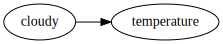

In [21]:
from graphviz import Source
Source('digraph{rankdir=LR; cloudy -> temperature}')

In [5]:
def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

g = weather()
print(g)

('cloudy', 46.847618103027344)


However, `weather` is entirely independent of Pyro - it only calls PyTorch. **We need to turn it into a Pyro program if we want to use this model for anything other than sampling fake data.**


这个模型除生成假数据还能干嘛呢？定义观测数据用于变分推断，提取生成过程中间结果？

## Model with Pyro


The `pyro.sample` Primitive



In [12]:
%psource pyro.sample

def sample(name, fn, *args, **kwargs):
    """
    Calls the stochastic function `fn` with additional side-effects depending
    on `name` and the enclosing context (e.g. an inference algorithm).
    See `Intro I <http://pyro.ai/examples/intro_part_i.html>`_ and
    `Intro II <http://pyro.ai/examples/intro_part_ii.html>`_ for a discussion.

    :param name: name of sample
    :param fn: distribution class or function
    :param obs: observed datum (optional; should only be used in context of
        inference) optionally specified in kwargs
    :param dict infer: Optional dictionary of inference parameters specified
        in kwargs. See inference documentation for details.
    :returns: sample
    """
    obs = kwargs.pop("obs", None)
    infer = kwargs.pop("infer", {}).copy()
    # check if stack is empty
    # if stack empty, default behavior (defined here)
    if not am_i_wrapped():
        if obs is not None:
            warnings.warn("trying to observe a value outside of inferen

In [15]:
# 到底该样本的名字用在哪里？怎么获取？
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)


tensor(1.2663)


In [7]:
torch.distributions.Normal(loc, scale).rsample(), pyro.distributions.Normal(loc, scale).rsample(), \
torch.distributions.Normal(loc, scale), pyro.distributions.Normal(loc, scale)

(tensor(-1.7534),
 tensor(0.6033),
 Normal(loc: 0.0, scale: 1.0),
 Normal(loc: 0.0, scale: 1.0))

Just like a direct call to `torch.distributions.Normal().rsample()`, this returns a sample from the unit normal distribution. **The crucial difference** is that this sample is _named_. Pyro's backend uses these names to uniquely identify sample statements and _change their behavior at runtime_ depending on how the enclosing stochastic function is being used. As we will see, this is how Pyro can implement the various manipulations that underlie inference algorithms.

---

重要区别是一个有名字，一个没有名字。后段会在抽样声明中使用这个名字。**那么究竟如何使用这个名字呢？** 可能是用 `pyro.param` 。

Now that we've introduced `pyro.sample` and `pyro.distributions` we can rewrite our simple model as a Pyro program:

In [20]:
def weather():
    cloudy = pyro.sample('cloudy', pyro.distributions.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', pyro.distributions.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('cloudy', 64.5440444946289)
('sunny', 94.37557983398438)
('sunny', 72.5186767578125)


Procedurally, `weather()` is still a non-deterministic Python callable that returns two random samples. Because the randomness is now invoked with `pyro.sample`, however, it is much more than that. In particular `weather()` specifies a joint probability distribution over two named random variables: `cloudy` and `temp`. As such, **it defines a probabilistic model that we can reason about using the techniques of probability theory.** For example we might ask: if I observe a temperature of 70 degrees, how likely is it to be cloudy? How to formulate and answer these kinds of questions will be the subject of the next tutorial.

## 一般随机函数

**Universality: Stochastic Recursion, Higher-order Stochastic Functions, and Random Control Flow**

We've now seen how to define a simple model. Building off of it is easy. For example:

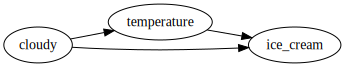

In [1]:
from graphviz import Source
Source('digraph{rankdir=LR; cloudy -> temperature -> ice_cream; cloudy -> ice_cream}')

In [22]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream

ice_cream_sales()

tensor(206.0483)

**This kind of modularity, familiar to any programmer, is obviously very powerful.** But is it powerful enough to encompass all the different kinds of models we'd like to express?

---

这种模块化是非常强大的. 下面给出一个随机控制得到几何分布的例子.


几何分布：

一种方程思维是 $T = \sum_{i=1}^{T-1}I(X_i = 0) + I(X_T = 1)$, 这个似乎没有什么用, 还是从定义出发, 第一次抽样到 1 的次数. 这种 X 与 T 之间的依赖关系非常奇怪. 事实上 $T = ~(X_1, X_2, ...)$, T本质上只与 X 的样本序列有关系, 有一个时间维度. 

In [42]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p)) # 这里体现了样本名字的作用！！！
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)
    
print(geometric(0.5))

3


Note that the names `x_0`, `x_1`, etc., in `geometric()` are generated dynamically and that different executions can have different numbers of named random variables. 

We are also free to define stochastic functions that accept as input or produce as output other stochastic functions:

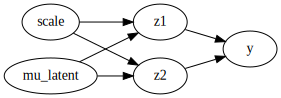

In [47]:
from graphviz import Source
Source('digraph{rankdir=LR; scale, mu_latent -> z1, z2 -> y}')

In [48]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", pyro.distributions.Normal(loc, scale))
    z2 = pyro.sample("z2", pyro.distributions.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal():
    mu_latent = pyro.sample("mu_latent", pyro.distributions.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

print(make_normal_normal()(1.))

tensor(0.7048)


Pyro 是可以构建通复杂随机函数，模拟各种数据生成过程，是一门通用的概率编程语言。

## Next Steps？

从先验分布到后验分布。